In [ ]:
!pip install minigrid
import minigrid
import minigrid.e
import nvs as envsS

import numpy as np

ModuleNotFoundError: No module named 'minigrid.e'

# 1. Create dataset

In [ ]:
env = envs.MultiRoomEnv(2, 4)
observation, info = env.reset(seed=42)

num_samples = 100000
prev_ob = observation

data = []
actions = []
for _ in range(num_samples):

	# Choose randomly from the action space
   action = env.action_space.sample() # User-defined policy function
   observation, reward, terminated, truncated, info = env.step(action)
   #print(action)
   #print(observation)

   next_ob = observation

   # Store the data
   actions.append(action)
   data.append((prev_ob['image'], next_ob['image']))

env.close()

data = np.array(data)
actions = np.array(actions)
print(f"Actions shape: {actions.shape}")
print(f"Data shape: {data.shape}")

Actions shape: (100000,)
Data shape: (100000, 2, 7, 7, 3)


In [ ]:
# selected_slice = data[:, 0, :, :, 0]

# # Check where the values are greater than 2
# greater_than_2 = selected_slice > 2

# # Count samples with any value > 2 in the 3D slice
# count = np.sum(np.any(greater_than_2, axis=(1, 2)))
# print(count)

### 1.1 Min max values from dataset

Useful to know what the size of one-hot encoded arrey will be

In [ ]:
# Find min - max values
min_val = np.min(data[0:])
max_val = np.max(data[0:])
unique_val  = len(np.unique(data))
print(f"Max-min values from the data: {min_val}, {max_val}, number of unique values: {unique_val}, which are: {np.unique(data)}")
print(f"Type saved in data: {data.dtype}")

min_val = np.min(actions)
max_val = np.max(actions)
unique_val  = len(np.unique(actions))
print(f"Max-min values from the actions: {min_val}, {max_val}, number of unique values: {unique_val}, which are: {np.unique(actions)}")
print(f"Type saved in actions: {actions.dtype}")

Max-min values from the data: 0, 8, number of unique values: 7, which are: [0 1 2 3 4 5 8]
Type saved in data: uint8
Max-min values from the actions: 0, 6, number of unique values: 7, which are: [0 1 2 3 4 5 6]
Type saved in actions: int64


### 1.2 One-hot encoding

Create a identity matrix with 6 rows, and it indexes it by `data`

In [ ]:
pos_val = len(minigrid.core.constants.OBJECT_TO_IDX)
print(f"Possible values of objects idx: {pos_val}")

one_hot_data = np.eye(pos_val)[data]
print(f"One hot encoded shape: {one_hot_data.shape}")
print(f"Type saved in one hot encoded: {one_hot_data.dtype}")

pos_act_val = env.action_space.n
print(f"Possible values of actions idx: {pos_act_val}")

one_hot_actions = np.eye(pos_act_val)[actions]
print(f"One hot encoded shape: {one_hot_actions.shape}")
print(f"Type saved in one hot encoded: {one_hot_actions.dtype}")

Possible values of objects idx: 11
One hot encoded shape: (100000, 2, 7, 7, 3, 11)
Type saved in one hot encoded: float64
Possible values of actions idx: 7
One hot encoded shape: (100000, 7)
Type saved in one hot encoded: float64


### 1.3 Flatten the arrays & save them into X, y
* flatten arrays representing actions & states
> State: (7, 7, 3, `pos_val`) -> (7 * 7 * 3 * `pos_val`)
>
> Actions: int -> (`pos_val_act`)

* save into `X`, `y`
> `X` = ( `state`, `action`) [1617, 7] - after one hot encoding
>
> `y` = ( `next_state`) [1617] - after one hot encoding

In [ ]:
flatten_states = one_hot_data[:, 0].reshape(-1, 7*7*3*pos_val)
X = np.concatenate((flatten_states, one_hot_actions), axis=1)

y = one_hot_data[:, 1].reshape((-1, 7*7*3*pos_val))

print(f"Shapes of X and y: {X.shape}, {y.shape}")
print(f"Type saved in X: {X.dtype}")
print(f"Type saved in y: {y.dtype}")

Shapes of X and y: (100000, 1624), (100000, 1617)
Type saved in X: float64
Type saved in y: float64


# 2. Pytorch datasets
Using Tensors to be able to use the GPU

### 2.1 Setting device agnostic code

In [ ]:
import torch

device =  "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### 2.2 Setting data to tensors

Sending tensors to device to ensure that they are on the same device as the models

In [ ]:
X = torch.from_numpy(X).to(device).type(torch.float32)
y = torch.from_numpy(y).to(device).type(torch.float32)

print(f"Shapes of X and y: {X.shape}, {y.shape}")

Shapes of X and y: torch.Size([100000, 1624]), torch.Size([100000, 1617])


### 2.3 Split the data into train (`train_X`, `train_y`) and test (`test_X`, `test_y`)

In [ ]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

print(f"Shapes of train_X and train_y: {train_X.shape}, {train_y.shape}")
print(f"Shapes of test_X and test_y: {test_X.shape}, {test_y.shape}")

Shapes of train_X and train_y: torch.Size([80000, 1624]), torch.Size([80000, 1617])
Shapes of test_X and test_y: torch.Size([20000, 1624]), torch.Size([20000, 1617])


### 2.4 Create batches

Thanks to that the training will be more efficient
I will use

mini batch of size -> `32`

In [ ]:
from torch import Tensor
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(train_X,
                              train_y)

train_loader = DataLoader(train_dataset,
                          batch_size=32,
                          #num_workers=2,
                          shuffle=True,
                          )

test_dataset = TensorDataset(test_X,
                             test_y)

test_loader = DataLoader(test_dataset,
                         #num_workers=2,
                         batch_size=32,
                         shuffle=False)



print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Train loader: {train_loader}")
print(f"Test loader: {test_loader}")

Train dataset size: 80000
Test dataset size: 20000
Train loader: <torch.utils.data.dataloader.DataLoader object at 0x7c072bef7f40>
Test loader: <torch.utils.data.dataloader.DataLoader object at 0x7c072bef5ff0>


### 2.5 Make train and test iteratable

In [ ]:
train_X, train_y = next(iter(train_loader))
test_X, test_y = next(iter(test_loader))

print(f"Shapes of train_X and train_y: {train_X.shape}, {train_y.shape}")
print(f"Shapes of test_X and test_y: {test_X.shape}, {test_y.shape}")

Shapes of train_X and train_y: torch.Size([32, 1624]), torch.Size([32, 1617])
Shapes of test_X and test_y: torch.Size([32, 1624]), torch.Size([32, 1617])


## 3. Models

We need 2 models (that will work as state to state transitions):
* Model that makes based on the given state gives next state
* Model that based on the given state will show previous state

The models will be NN networks, trained on dataset gathered in previous section.

*Isnt the network of the same architecture for the both `Predict Next state` and `Predict Previous state` ? - I think it is.

> What differs is, how they are trained then
* treat next state as targets
* treat next state as input

### 3.1 NN state_next_state

In [ ]:
from torch import nn

class NNStateNextState(nn.Module):
  def __init__(self, input_size, state_size_encoded):
    super().__init__()

    self.layers = nn.Sequential(
        nn.Linear(in_features=input_size, out_features=1000),
        nn.ReLU(),
        nn.Linear(in_features=1000, out_features=500),
        nn.ReLU(),
        nn.Linear(in_features=500, out_features=500),
        nn.ReLU(),
        nn.Linear(in_features=500, out_features=1000),
        nn.ReLU(),
        nn.Linear(in_features=1000, out_features=state_size_encoded),
        nn.ReLU(),
        nn.Linear(in_features=state_size_encoded, out_features=state_size_encoded),
    )

  def forward(self, x):
    return self.layers(x)

input_size = train_X.shape[1]
state_size_encoded = train_y.shape[1]
next_state_nn = NNStateNextState(input_size=input_size,
                                 state_size_encoded=state_size_encoded
                                 ).to(device)
next_state_nn

NNStateNextState(
  (layers): Sequential(
    (0): Linear(in_features=1624, out_features=1000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1000, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=500, bias=True)
    (5): ReLU()
    (6): Linear(in_features=500, out_features=1000, bias=True)
    (7): ReLU()
    (8): Linear(in_features=1000, out_features=1617, bias=True)
    (9): ReLU()
    (10): Linear(in_features=1617, out_features=1617, bias=True)
  )
)

### 3.2 Set optimizer & loss_function

In [ ]:
optimizer = torch.optim.SGD(next_state_nn.parameters(),
                            lr=0.1)
#optimizer = torch.optim.Adam(next_state_nn.parameters(),
#                             lr=0.001)
loss_fn = torch.nn.MSELoss()

### 3.3 Define the accuracy function for states

In [ ]:
def accuracy_fn(pred_states, true_states):
  return sum([1 if torch.all(pred_state == true_state) else 0 for pred_state, true_state in zip(pred_states, true_states) ]) / len(pred_states) * 100

## 4. Experiments

### 4.1 Define training loop

In [ ]:
from tqdm.auto import tqdm

def training_step(model, epochs, data_loader, loss_fn, accuracy_fn, optimizer, device):
  model.train()

  for epoch in tqdm(range(epochs)):
    train_loss = 0
    train_acc = 0

    total_batches = len(data_loader)
    for batch, (X, y) in enumerate(data_loader):
      X, y = X.to(device), y.to(device)

      y_pred = torch.sigmoid(model(X))
      loss = loss_fn(y_pred, y)
      train_loss += loss


      #### To get argmax matching
      y_pred = y_pred.reshape((32, 7, 7, 3, 11))
      max_indices = y_pred.argmax(dim=4)
      result = torch.zeros_like(y_pred)

      result[torch.arange(y_pred.shape[0]).unsqueeze(1).unsqueeze(2).unsqueeze(3),
          torch.arange(y_pred.shape[1]).unsqueeze(0).unsqueeze(2).unsqueeze(3),
          torch.arange(y_pred.shape[2]).unsqueeze(0).unsqueeze(1).unsqueeze(3),
          torch.arange(y_pred.shape[3]).unsqueeze(0).unsqueeze(1).unsqueeze(2),
          max_indices] = 1
      flattened_result = result.view(32, -1)
      ####
      acc = accuracy_fn(flattened_result, y)
      train_acc += acc

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      #if batch % 400 == 0:
      #print(f"Loss {loss} ")
        #print(f"Epoch: {epoch} | Batch: {batch} | Loss: {loss.item()} | Accuracy: {acc}")

    train_loss /= len(train_dataset)
    train_acc /= len(train_dataset)

    print(f"Epoch: {epoch} | Loss: {train_loss} | Accuracy: {train_acc}%")


### 4.2 Define testing loop

In [ ]:
def testing_step(model, data_loader, loss_fn, accuracy_fn, device):
  model.eval()
  test_loss = 0
  test_acc = 0

  pred_states = []
  true_states = []
  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)
      # print shape of y
      # print(y.shape)

      test_pred = torch.sigmoid(model(X))
      # print shape of test_pred
      # print(test_pred.shape)
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(torch.round(test_pred), y)

      pred_states.append(test_pred)
      true_states.append(y)

    test_loss /= len(test_dataset)
    test_acc /= len(test_dataset)

    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")
    return pred_states, true_states

In [ ]:
#show shapes of train_loader, test_loader
@torch.no_grad()
def show_shapes(train_loader, test_loader):
  train_X, train_y = next(iter(train_loader))
  test_X, test_y = next(iter(test_loader))
  print(f"Shapes of train_X and train_y: {train_X.shape}, {train_y.shape}")
  print(f"Shapes of test_X and test_y: {test_X.shape}, {test_y.shape}")
  print(f"Train dataset size: {len(train_dataset)}")
  print(f"Test dataset size: {len(test_dataset)}")
  print(f"Train loader: {train_loader}")
  print(f"Test loader: {test_loader}")

show_shapes(train_loader, test_loader)

Shapes of train_X and train_y: torch.Size([32, 1624]), torch.Size([32, 1617])
Shapes of test_X and test_y: torch.Size([32, 1624]), torch.Size([32, 1617])
Train dataset size: 80000
Test dataset size: 20000
Train loader: <torch.utils.data.dataloader.DataLoader object at 0x7c072bef7f40>
Test loader: <torch.utils.data.dataloader.DataLoader object at 0x7c072bef5ff0>


In [ ]:
training_step(next_state_nn, 5, train_loader, loss_fn, accuracy_fn, optimizer, device)
print("-------------")
pred_states, test_states = testing_step(next_state_nn, test_loader, loss_fn, accuracy_fn, device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Loss: 0.0042485445737838745 | Accuracy: 0.0%
Epoch: 1 | Loss: 0.0007388145895674825 | Accuracy: 0.0%
Epoch: 2 | Loss: 0.0007382609182968736 | Accuracy: 0.0%
Epoch: 3 | Loss: 0.000738085771445185 | Accuracy: 0.0%
Epoch: 4 | Loss: 0.00073806825093925 | Accuracy: 0.0%
-------------
Test loss: 0.00074 | Test accuracy: 0.00%



## 5. Visualize states

In [ ]:
print(len(test_states), len(pred_states))

625 625


### 5.1 Prepare 1st batch

In [ ]:
### First batch

import torch

# Extract the first batch of data from the test_loader
test_X, test_y = next(iter(test_loader))
print(f"Number of test samples: {len(test_y)}")

# Ensure `random_indices` is a list for indexing
random_indices = torch.randperm(len(test_y))[:5].tolist()  # Randomly select 5 indices

# Select samples using the random indices
chosen_test_X_loader = torch.stack([test_X[idx] for idx in random_indices])#.reshape(5, 7, 7, 3, 11)  # Stack tensors into a new tensor
# chosen_test_y_loader = torch.stack([test_y[idx] for idx in random_indices]).reshape(5, 7, 7, 3, 11)

# For train actions
chosen_train_actions = torch.stack([chosen_test_X_loader[i, 1617:] for i in range(len(random_indices))])
chosen_test_X_loader = chosen_test_X_loader[:, :1617].reshape((5, 7, 7, 3, 11))

# Handle `pred_states` and `test_states` as lists
print(len(pred_states))
chosen_pred_states = pred_states[0][random_indices].reshape((5, 7, 7, 3, 11))
chosen_true_states = test_states[0][random_indices].reshape((5, 7, 7, 3, 11))

# Print shapes for verification
print("Chosen Test X Loader Shape:", chosen_test_X_loader.shape)
# print("Chosen Test y Loader Shape:", chosen_test_y_loader.shape)
print("Chosen Train Actions Shape:", chosen_train_actions.shape)
print("Chosen Pred States Shape:", chosen_pred_states.shape)
print("Chosen True States Shape:", chosen_true_states.shape)


Number of test samples: 32
625
Chosen Test X Loader Shape: torch.Size([5, 7, 7, 3, 11])
Chosen Train Actions Shape: torch.Size([5, 7])
Chosen Pred States Shape: torch.Size([5, 7, 7, 3, 11])
Chosen True States Shape: torch.Size([5, 7, 7, 3, 11])


### 5.2 Last batch

In [ ]:
### Last batch
import torch

# Get the total number of batches in the test_loader
total_batches = len(test_loader)
print(f"Total number of batches: {total_batches}")

# Get the last batch of data from the test_loader
last_batch_X, last_batch_y = None, None
for batch_X, batch_y in test_loader:  # Iterate through the loader
    last_batch_X, last_batch_y = batch_X, batch_y  # Keep overwriting until the last batch

print(f"Number of samples in the last batch: {len(last_batch_y)}")

# Select the last 5 samples from the last batch
last_indices = list(range(len(last_batch_y) - 5, len(last_batch_y)))  # Indices for the last 5 samples

# Select samples using the last indices
chosen_test_X_loader = torch.stack([last_batch_X[idx] for idx in last_indices])  # Stack tensors into a new tensor
chosen_test_X_loader = chosen_test_X_loader[:, :1617].reshape((5, 7, 7, 3, 11))

# For train actions
chosen_train_actions = torch.stack([last_batch_X[idx, 1617:] for idx in last_indices])

# Assuming `pred_states` and `test_states` are tensors or
chosen_pred_states = pred_states[-1][random_indices].reshape((5, 7, 7, 3, 11))
chosen_true_states = test_states[-1][random_indices].reshape((5, 7, 7, 3, 11))

# Print shapes for verification
print("Chosen Test X Loader Shape:", chosen_test_X_loader.shape)
print("Chosen Train Actions Shape:", chosen_train_actions.shape)
print("Chosen Pred States Shape:", chosen_pred_states.shape)
print("Chosen True States Shape:", chosen_true_states.shape)


Total number of batches: 625
Number of samples in the last batch: 32
Chosen Test X Loader Shape: torch.Size([5, 7, 7, 3, 11])
Chosen Train Actions Shape: torch.Size([5, 7])
Chosen Pred States Shape: torch.Size([5, 7, 7, 3, 11])
Chosen True States Shape: torch.Size([5, 7, 7, 3, 11])


### 5.3 Heatmap as a state

torch.Size([7, 7, 3])


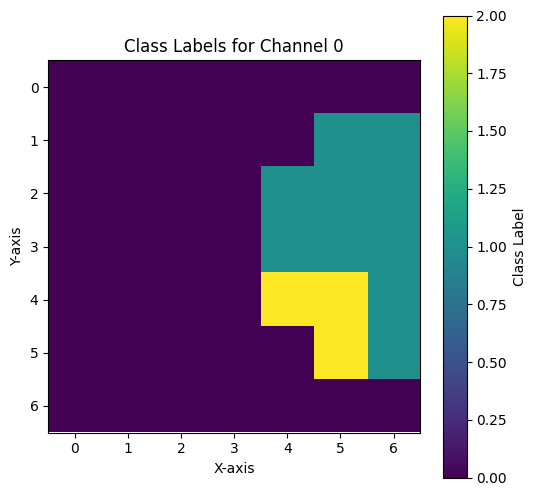

In [ ]:
import matplotlib.pyplot as plt
#print(torch.round(pred_states).shape)#.reshape((7, 7, 3, 11))))

#print(pred_states.shape)
pred_states = chosen_pred_states[0]#[0]).reshape((7, 7, 3, 11))#.reshape((7, 7, 3, 11)))  # Reshape first

# Convert one-hot encoded vectors to class labels
class_labels = pred_states.argmax(dim=3)  # Apply argmax along the last dimension

print(class_labels.shape)
## torch.Size([7, 7, 3]) - 3 channels (OBJ_IDX, STATE_IDX, ?? )

# Extract the first channel of the class labels for plotting
class_labels_channel_0 = class_labels[:, :, 0]
# TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.
class_labels_channel_0 = class_labels_channel_0.cpu().numpy()

# Plotting class_labels_channel_0 as a color map
plt.figure(figsize=(6, 6))
plt.imshow(class_labels_channel_0, cmap='viridis', interpolation='nearest')
plt.colorbar(label="Class Label")
plt.title("Class Labels for Channel 0")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()

### 5.4 Save states to files

In [ ]:
import matplotlib.pyplot as plt

# Iterate over the 5 samples to save combined heatmaps
for i in range(5):
    # Initialize a figure with 1 row and 4 columns (one for action, three for heatmaps)
    fig, axs = plt.subplots(1, 4, figsize=(18, 6))
    fig.suptitle(f"Sample {i}: Action and Heatmaps", fontsize=16)

    # Display the action
    action = chosen_train_actions[i].cpu().numpy() if isinstance(chosen_train_actions[i], torch.Tensor) else chosen_train_actions[i]
    axs[0].text(0.5, 0.5, f"Action: {action.argmax()}", fontsize=14, ha='center', va='center')
    axs[0].axis('off')  # Hide axis for the action display
    axs[0].set_title("Action", fontsize=12)

    # Define the states for heatmaps
    states = {
        "Train": chosen_test_X_loader[i],
        "Predicted": chosen_pred_states[i],
        "True": chosen_true_states[i],
    }

    # Generate heatmaps for Train, Predicted, and True states
    for ax, (state_name, state_tensor) in zip(axs[1:], states.items()):
        # Convert one-hot encoded vectors to class labels
        class_labels = state_tensor.argmax(dim=3)  # Apply argmax along the last dimension
        # Extract the first channel of the class labels for plotting
        heatmap_data = class_labels[:, :, 0].cpu().numpy()

        # Plot the heatmap
        im = ax.imshow(heatmap_data, cmap="viridis", interpolation="nearest")
        ax.set_title(f"{state_name} Heatmap", fontsize=12)
        ax.set_xlabel("X-axis")
        ax.set_ylabel("Y-axis")

        # Add a color bar
        plt.colorbar(im, ax=ax, orientation="vertical")

    # Adjust layout and save the figure
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f"combined_heatmaps_sample_{i}.png")
    plt.close()
    print(f"combined_heatmaps_sample_{i}.png saved")


combined_heatmaps_sample_0.png saved
combined_heatmaps_sample_1.png saved
combined_heatmaps_sample_2.png saved
combined_heatmaps_sample_3.png saved
combined_heatmaps_sample_4.png saved
